In [1]:
# todo 
# evaluation metric match, data loading also matches - without transliteration. transliteration changes things a little bit.
# make an all in one notebook..


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import json
from IPython.display import display, HTML
import difflib
from termcolor import colored
import unicodedata
import pandas as pd
from aksharamukha import transliterate
from matplotlib.patches import Rectangle
import textwrap
%matplotlib inline

In [2]:
# Define the file path
ratio_number = 10
experiment_number = f'data_efficiency_{ratio_number:02}'#"big_7pgtrained_1x" 
#threshold = 0.50 # heuristic threshold
gcer=True

###
fold_1_path = f'/home/ocr_proj/OCR/post_correction/pe-ocr-sanskrit/outputs/experiment_{experiment_number}/test_fold_1/'

## Helper Fuctions

### Visualizations Functions

In [3]:
def highlight_changes(line1, line2):
    # Generate a diff between the two lines
    diff = list(difflib.ndiff(line1, line2))

    # Create colored output based on diff
    highlighted_line1 = []
    highlighted_line2 = []

    i = 0
    while i < len(diff):
        if diff[i].startswith('- ') and i+1 < len(diff) and diff[i+1].startswith('+ '):
            # Replace operation
            highlighted_line1.append(colored(diff[i][2:], 'yellow'))
            highlighted_line2.append(colored(diff[i+1][2:], 'yellow'))
            i += 2
        elif diff[i].startswith('- '):
            # Delete operation
            highlighted_line1.append(colored(diff[i][2:], 'blue'))
            highlighted_line2.append(colored(' ', 'blue'))
            i += 1
        elif diff[i].startswith('+ '):
            # Insert operation
            highlighted_line1.append(colored(' ', 'red'))
            highlighted_line2.append(colored(diff[i][2:], 'red'))
            i += 1
        elif diff[i].startswith('  '):
            # Unchanged characters
            highlighted_line1.append(diff[i][2:])
            highlighted_line2.append(diff[i][2:])
            i += 1
        else:
            # Skip '?' lines
            i += 1

    final_line1 = ''.join(highlighted_line1)
    final_line2 = ''.join(highlighted_line2)

    # Ensure equal length by padding with spaces
    max_length = max(len(final_line1), len(final_line2))
    final_line1 = final_line1.ljust(max_length)
    final_line2 = final_line2.ljust(max_length)


    print("Ground Truth  : " + final_line2)
    print("Prediction    : " + final_line1)


# Example usage:
highlight_changes("abcdef", "abxcef")

def analyse_line(df,id):

    first_image_path = df['path'].iloc[id]    
    # Load and display the image using matplotlib
    img = mpimg.imread(first_image_path)

    # Print legend
    print(colored("Blue     ", "blue") + ": Extra")
    print(colored("Red   ", "red") + ": Missing")
    print(colored("Yellow  ", "yellow") + ": Replaced")
    print("No color: Unchanged")
    print('\n')

    # df['partial_cnnlstm_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_cnnlstm_text'],gcer=True,transliteration=True), axis=1)
    # df['partial_llm_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_llm_text'],gcer=True,transliteration=True), axis=1)
    # df['pure_cnnlstm_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['pure_cnnlstm_text'],gcer=True,transliteration=True), axis=1)

    # df['partial_cnnlstm_cer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_cnnlstm_text'],gcer=False,transliteration=True), axis=1)
    # df['partial_llm_cer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_llm_text'],gcer=False,transliteration=True), axis=1)
    # df['pure_cnnlstm_cer'] = df.apply(lambda row: calculate_error(row['target_text'], row['pure_cnnlstm_text'],gcer=False,transliteration=True), axis=1)


    # df['imporvement_llm_gcer'] = df['partial_llm_gcer'] - df['partial_cnnlstm_gcer'] #difference_gcer
    # df['imporvement_cnnlstm_gcer'] = df['pure_cnnlstm_gcer'] - df['partial_cnnlstm_gcer']

    # df['imporvement_llm_cer'] = df['partial_llm_cer'] - df['partial_cnnlstm_cer']  #difference
    # df['imporvement_cnnlstm_cer'] = df['pure_cnnlstm_cer'] - df['partial_cnnlstm_cer']


    plt.figure(figsize=(30, 30))
    plt.axis('off')
    plt.imshow(img, cmap='gray')


    # 7  Page CNN-LSTM              
    # 7  Page CNN-LSTM + 33 Page LLM
    # 40 Page CNN-LSTM              

    print(f'7  Page CNN-LSTM                 GCER:{str(df['partial_cnnlstm_gcer'].iloc[id]*100)} CER:{str(df['partial_cnnlstm_cer'].iloc[id]*100)}')
    highlight_changes(df['partial_cnnlstm_text'].iloc[id], df['target_text'].iloc[id])
    print('')
    print(f'7  Page CNN-LSTM + 33 Page LLM   GCER:{str(df['partial_llm_gcer'].iloc[id]*100)} CER:{str(df['partial_llm_cer'].iloc[id]*100)}')#
    highlight_changes(df['partial_llm_text'].iloc[id], df['target_text'].iloc[id])
    print('')
    print(f'40 Page CNN-LSTM                 GCER:{str(df['pure_cnnlstm_gcer'].iloc[id]*100)} CER:{str(df['pure_cnnlstm_cer'].iloc[id]*100)}')
    highlight_changes(df['pure_cnnlstm_text'].iloc[id], df['target_text'].iloc[id])

    

    print('\nOriginal Line Image:')


def format_json(data):
    # Recursive function to format JSON data
    def format_item(item):
        if isinstance(item, dict):
            formatted = "<ul>"
            for key, value in item.items():
                formatted += f"<li><strong>{key}:</strong> {format_item(value)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        elif isinstance(item, list):
            formatted = "<ul>"
            for sub_item in item:
                formatted += f"<li>{format_item(sub_item)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        else:
            return f"<span>{item}</span>"
    
    return format_item(data)

def display_side_by_side(json_data1, json_data2, title1="JSON File 1", title2="JSON File 2"):
    formatted_json1 = format_json(json_data1)
    formatted_json2 = format_json(json_data2)
    
    # Create HTML for side-by-side display
    html = f"""
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title1}</h3>
            {formatted_json1}
        </div>
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title2}</h3>
            {formatted_json2}
        </div>
    </div>
    """
    
    display(HTML(html))
    return HTML(html)




Ground Truth  : abxc ef
Prediction    : ab cdef


### Evaluation Functions

In [4]:
### EVALUATION FUNCTIONS BELOW


def list_correct_grapheme_clusters(devanagari_string):
    combining_marks = {'्', 'ँ', 'ं', 'ः', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॢ', 'ॣ', 'े', 'ै', 'ो', 'ौ', '़','ॅ'}
    graphemes = []
    temp_grapheme = ""
    for char in devanagari_string:
        if unicodedata.combining(char) == 0 and char not in combining_marks:
            # If temp_grapheme has something and last char was not virama, append to graphemes
            if temp_grapheme and not temp_grapheme.endswith('्'):
                graphemes.append(temp_grapheme)
                temp_grapheme = char
            else:
                temp_grapheme += char
        else:
            temp_grapheme += char  # Add combining mark or virama to current grapheme

    # Append the last grapheme if exists
    if temp_grapheme:
        graphemes.append(temp_grapheme)

    return graphemes


def non_matching_graphemes(s, s1):

    # Split both strings into graphemes
    graphemes_s = list_correct_grapheme_clusters(s)
    graphemes_s1 = list_correct_grapheme_clusters(s1)

    # Find the LCS to align graphemes instead of characters
    m, n = len(graphemes_s), len(graphemes_s1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if graphemes_s[i - 1] == graphemes_s1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Reconstruct the sequence of non-matching graphemes
    non_matching = []
    error_count = 0
    while m > 0 and n > 0:
      # if the grapheme clusters match
        if graphemes_s[m - 1] == graphemes_s1[n - 1]:
            m, n = m - 1, n - 1

      # if they dont match
        else:
            temp_s, temp_s1 = "", ""

            while m > 0 and (n == 0 or dp[m][n] == dp[m-1][n]):
                temp_s = graphemes_s[m - 1] + temp_s
                m -= 1

            while n > 0 and (m == 0 or dp[m][n] == dp[m][n-1]):
                temp_s1 = graphemes_s1[n - 1] + temp_s1
                n -= 1

            # if(len(temp_s)>3):
              # print(list_correct_grapheme_clusters(temp_s))
            if(len(list_correct_grapheme_clusters(temp_s))>=len(list_correct_grapheme_clusters(temp_s1))):

              temp_list = list_correct_grapheme_clusters(temp_s)

            else:
              temp_list = list_correct_grapheme_clusters(temp_s1)

            temp_list.reverse()
            error_count += len(temp_list)
            non_matching.extend(temp_list)

    # print(m,n)
    non_matching.reverse()
    # print(non_matching)
    # print(graphemes_s)
    return(error_count/len(graphemes_s))

def longest_common_subsequence(s, s1):
    # Create the DP table
    m, n = len(s), len(s1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Fill the DP table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s[i - 1] == s1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Reconstruct the LCS
    lcs = []
    while m > 0 and n > 0:
        if s[m - 1] == s1[n - 1]:
            lcs.append(s[m - 1])
            m -= 1
            n -= 1
        elif dp[m - 1][n] > dp[m][n - 1]:
            m -= 1
        else:
            n -= 1

    # The LCS is built backwards, so reverse it
    return ''.join(reversed(lcs))

def get_unicode_eval(pg_annot,pg_pred):
    s = pg_pred
    s1 = pg_annot

    lcs = longest_common_subsequence(s, s1)
    #   print(lcs)
    # print(modelname+" LCS: "+f'{len(lcs)/len(s)}')
    denom = len(s1) if len(s1)>= len(s) else len(s)
    return(1-(len(lcs)/denom))

def calculate_gcer(pg_annot,pg_pred,transliteration=False):
    if transliteration:
        pg_annot = transliterate.process( 'IAST', 'Devanagari', pg_annot)
        pg_pred = transliterate.process( 'IAST', 'Devanagari', pg_pred)

    errors = non_matching_graphemes(pg_annot, pg_pred)
    return errors

def calculate_cer(pg_annot,pg_pred,transliteration=False):
    if transliteration:
        pg_annot = transliterate.process( 'IAST', 'Devanagari', pg_annot)
        pg_pred = transliterate.process( 'IAST', 'Devanagari', pg_pred)

    errors = get_unicode_eval(pg_annot, pg_pred)
    return errors

def calculate_error(transcript,partial_llm_text,gcer=False,transliteration=True):
    if gcer:
        error = calculate_gcer(transcript,partial_llm_text,transliteration=transliteration)
    else:
        error = calculate_cer(transcript,partial_llm_text,transliteration=transliteration)
    return error


## Dataframe Preparation

In [5]:
csv_file_path_1 = fold_1_path +'analysis.csv'
df_1 = pd.read_csv(csv_file_path_1, delimiter=';', encoding='utf-8')
df = pd.concat([df_1], axis=0, ignore_index=True)

#drop these columns
df = df.drop('difference', axis=1)
df = df.drop('pre_cer', axis=1)
df = df.drop('post_cer', axis=1)

In [6]:
# LOADING THE PURE CNN-LSTM PREDICTIONS
#_ocred_text_path = f'/home/ocr_proj/OCR/vPostNAAC/line_pred/test_big_big_51.txt'  #example: val_clean_clean_12
_ocred_text_path = f'/home/ocr_proj/OCR/vPostNAAC/line_images/test_big_40/pred.txt'
with open(_ocred_text_path, 'rt') as myfile:
    pure_cnnlstm_ocred_text = myfile.read().split('\n')[:-1]  #CHANGED
assert len(df.iloc[:,0]) == len(pure_cnnlstm_ocred_text)
_ = [transliterate.process( 'Devanagari', 'IAST', txt) for txt in pure_cnnlstm_ocred_text]
df['pure_cnnlstm_text'] = _

df.rename(columns={'input_text': 'partial_cnnlstm_text'}, inplace=True)
df.rename(columns={'predicted_text': 'partial_llm_text'}, inplace=True)

In [7]:
df.head()

,partial_cnnlstm_text,target_text,partial_llm_text,path,pure_cnnlstm_text
0,masabaṃdhasyaprāthamikabodheevaviṣayatvāpatteś...,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...
1,tanyathānupapatyābhāvanāpibhighataïtisiddhāṃta...,nyathānupapatyābhāvanāpibhidyataïtisiddhāṃtaḥs...,tanyathānupapatyābhāvanāpibhidyataïtisiddhāṃta...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...,nyathānupapatyābhabhāvanāpibhidataïtisiddhāṃta...
2,panvayanadhātvarthananvayāt.saṃkhyāyāapyupadār...,panvayenadhātvarthe'nanvayāt.saṃkhyāyāapyupadā...,panvayenadhātvarthenanvayāt.saṃkhyāyāapyupadār...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...,panvayenadhātvarthenanvayāt.saṃkhyāyāapyupadār...
3,stadanyathānupapatyācayāgabhadaïtivaiparītyamā...,stadanyathānupapatyācayāgabhedaïtivaiparītyamā...,stadanyathānupapatyācayāgabhedaïtivaiparītyamā...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...,stadanyathānupapatyācayāgabhedaïtivaiparītyamā...
4,somenopapadārthena.tasmāhavalekapotanyāpenasar...,somenopapadārthena.tasmātkhalekapotanyāyenasar...,somenopapadārthena.tasmādbalekapotanyāyenasarv...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...,somenopapadārthena.tasmātalekapotanyāyenasarve...


In [8]:
df['partial_cnnlstm_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_cnnlstm_text'],gcer=True,transliteration=True), axis=1)
df['partial_llm_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_llm_text'],gcer=True,transliteration=True), axis=1)
df['pure_cnnlstm_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['pure_cnnlstm_text'],gcer=True,transliteration=True), axis=1)

df['partial_cnnlstm_cer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_cnnlstm_text'],gcer=False,transliteration=True), axis=1)
df['partial_llm_cer'] = df.apply(lambda row: calculate_error(row['target_text'], row['partial_llm_text'],gcer=False,transliteration=True), axis=1)
df['pure_cnnlstm_cer'] = df.apply(lambda row: calculate_error(row['target_text'], row['pure_cnnlstm_text'],gcer=False,transliteration=True), axis=1)


# CNN-LSTM vs LLM
df['imporvement_llm_gcer'] = df['partial_llm_gcer'] - df['partial_cnnlstm_gcer'] #difference_gcer
df['imporvement_cnnlstm_gcer'] = df['pure_cnnlstm_gcer'] - df['partial_cnnlstm_gcer']

# CNN-LSTM vs LLM
df['imporvement_llm_cer'] = df['partial_llm_cer'] - df['partial_cnnlstm_cer']  #difference
df['imporvement_cnnlstm_cer'] = df['pure_cnnlstm_cer'] - df['partial_cnnlstm_cer']

df['improvement_different'] = df['imporvement_llm_cer']-df['imporvement_cnnlstm_cer']

df = df.sort_values(by=['improvement_different'], ascending=True)

## Report

In [9]:
# # Plot histogram and get bin edges and counts
# plt.figure(figsize=(10, 6))
# if gcer:
#     counts, bin_edges, patches = plt.hist(df['imporvement_llm_gcer']*100, bins=20, edgecolor='black')
# else:
#     counts, bin_edges, patches = plt.hist(df['imporvement_llm_cer']*100, bins=20, edgecolor='black')

# # Normalize bin edges for color mapping
# norm = plt.Normalize(bin_edges.min(), bin_edges.max())

# # Create custom colormaps that are more color-blind friendly
# colors_neg = ['#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like
# colors_pos = ['#fee08b', '#fc8d59', '#d53e4f']  # YlOrRd-like

# cmap_neg = mcolors.LinearSegmentedColormap.from_list("custom_neg", colors_neg)
# cmap_pos = mcolors.LinearSegmentedColormap.from_list("custom_pos", colors_pos)

# # Apply colors to bars
# for i, patch in enumerate(patches):
#     # Determine bin edges
#     left_edge = bin_edges[i]
#     right_edge = bin_edges[i + 1]
    
#     # Check if bin includes zero
#     if left_edge <= 0 <= right_edge:
#         # Set the color of the bin that includes zero to gray
#         color = 'gray'
#     elif right_edge < 0:
#         # Color for bins with negative values
#         bin_center = (left_edge + right_edge) / 2
#         color = cmap_neg(norm(bin_center))
#     else:
#         # Color for bins with positive values
#         bin_center = (left_edge + right_edge) / 2
#         color = cmap_pos(norm(bin_center))
    
#     patch.set_facecolor(color)


# plt.xticks(ticks=bin_edges, fontsize=7)
# plt.yticks(fontsize=7)  # Decrease the font size of x-axis ticks
# # Format x-axis tick labels to one decimal place
# formatter = FuncFormatter(lambda x, _: f'{x:.1f}')
# plt.gca().xaxis.set_major_formatter(formatter)

# plt.title('How many lines does Post Correction benefit?')
# if gcer:
#     plt.xlabel('Change in Grapheme Cluster Error Rate (%)')
# else:
#     plt.xlabel('Change in Character Error Rate (%)')
# plt.ylabel('Number of Lines')

# # Show the plot
# plt.show()

In [10]:
abnormal_lines_values = []
abnormal_lines_indices = []

ocr_errors = []
post_correction_errors = []

imporvements_by_llm = []


for index, row in df.iterrows():

    partial_cnnlstm_text = str(row['partial_cnnlstm_text'])
    partial_llm_text = str(row['partial_llm_text'])
    target_text = str(row['target_text'])

    value_1 = len(partial_llm_text)/len(set(partial_llm_text))
    value_2 = len(partial_cnnlstm_text)/len(set(partial_cnnlstm_text))
    value = abs(value_2-value_1)



    ocr_error = calculate_error(target_text,partial_cnnlstm_text, gcer=gcer) #we need ground truth for this
    post_correction_error = calculate_error(target_text,partial_llm_text,gcer=gcer) # we need ground truth for this too
    
    ocr_errors.append(ocr_error)
    #post_correction_errors.append(post_correction_error)

    
    abnormal_lines_values.append(value)
    if value>0.8:
        print(row['target_text'])
        print(row['partial_llm_text'])
        print(index)
        abnormal_lines_indices.append(index)
        post_correction_errors.append(ocr_error)
        imporvements_by_llm.append(0.0)

    else:
        post_correction_errors.append(post_correction_error)
        if gcer:
            imporvements_by_llm.append(row['partial_llm_gcer'] - row['partial_cnnlstm_gcer'])
        else:
            imporvements_by_llm.append(row['partial_llm_cer'] - row['partial_cnnlstm_cer'])






syānirastatvāt..tasmātsomayāgayoḥsaṃbaṃdhopayuktakriyāyāḥpadādanupasthityānaprāthamikabodhetasya
syanirastatvāt..tasmātsomayāgayoḥsaṃbadheprāthamikabodhetasya
12


(array([19., 15.,  9.,  4.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.10119048, 0.20238095, 0.30357143, 0.4047619 ,
        0.50595238, 0.60714286, 0.70833333, 0.80952381, 0.91071429,
        1.01190476]),
 <BarContainer object of 10 artists>)

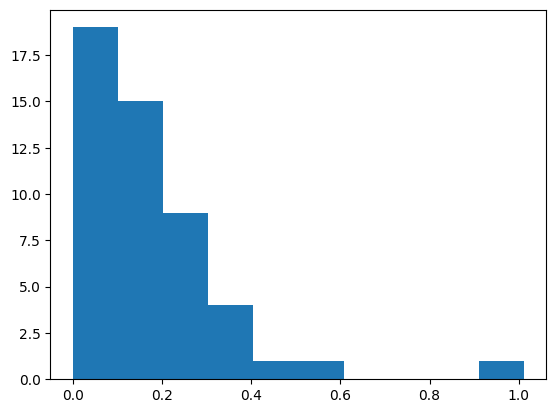

In [11]:
plt.hist(abnormal_lines_values)

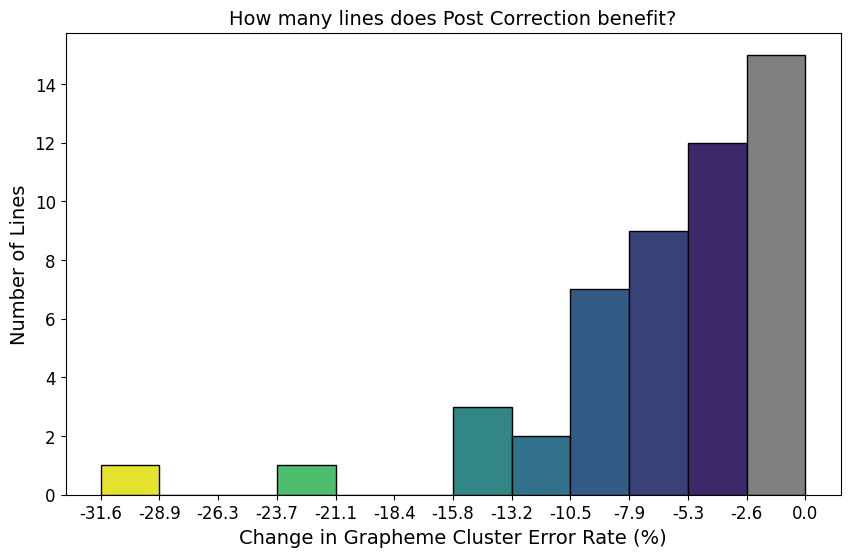

In [26]:
# Plot histogram and get bin edges and counts
plt.figure(figsize=(10, 6))

counts, bin_edges, patches = plt.hist([i*100 for i in imporvements_by_llm], bins=12, edgecolor='black')

# Normalize bin edges for color mapping
norm = plt.Normalize(bin_edges.min(), bin_edges.max())

# Create custom colormaps that are more color-blind friendly
colors_neg = ['#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like
colors_neg.reverse()
colors_pos = ['#fee08b', '#fc8d59', '#d53e4f']  # YlOrRd-like

cmap_neg = mcolors.LinearSegmentedColormap.from_list("custom_neg", colors_neg)
cmap_pos = mcolors.LinearSegmentedColormap.from_list("custom_pos", colors_pos)

# Apply colors to bars
for i, patch in enumerate(patches):
    # Determine bin edges
    left_edge = bin_edges[i]
    right_edge = bin_edges[i + 1]
    
    # Check if bin includes zero
    if left_edge <= 0 <= right_edge:
        # Set the color of the bin that includes zero to gray
        color = 'gray'
    elif right_edge < 0:
        # Color for bins with negative values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_neg(norm(bin_center))
    else:
        # Color for bins with positive values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_pos(norm(bin_center))
    
    patch.set_facecolor(color)


plt.xticks(ticks=bin_edges, fontsize=12)
plt.yticks(fontsize=12)  # Decrease the font size of x-axis ticks
# Format x-axis tick labels to one decimal place
formatter = FuncFormatter(lambda x, _: f'{x:.1f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('How many lines does Post Correction benefit?', fontsize = 14)
if gcer:
    plt.xlabel('Change in Grapheme Cluster Error Rate (%)', fontsize = 14)
else:
    plt.xlabel('Change in Character Error Rate (%)', fontsize = 14)
plt.ylabel('Number of Lines', fontsize = 14)

# Show the plot
plt.show()

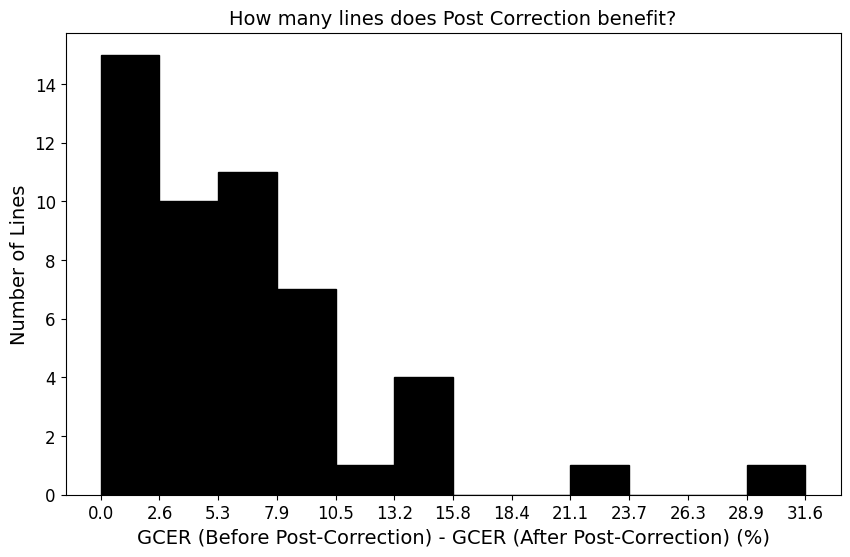

In [29]:
# Plot histogram and get bin edges and counts
plt.figure(figsize=(10, 6))

counts, bin_edges, patches = plt.hist([i*-100 for i in imporvements_by_llm], bins=12, edgecolor='black', color='black')

plt.xticks(ticks=bin_edges, fontsize=12)
plt.yticks(fontsize=12)  # Decrease the font size of x-axis ticks
# Format x-axis tick labels to one decimal place
formatter = FuncFormatter(lambda x, _: f'{x:.1f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('How many lines does Post Correction benefit?', fontsize=14)
if gcer:
    plt.xlabel('GCER (Before Post-Correction) - GCER (After Post-Correction) (%)', fontsize=14)
else:
    plt.xlabel('Change in Character Error Rate (%)', fontsize=14)
plt.ylabel('Number of Lines', fontsize=14)

# Show the plot
plt.show()

In [13]:
# good_pseudo = []
# bad_pseudo = []
# bad_pseudo_indices = []
# good_pseudo_indices = []

# ocr_errors = []
# post_correction_errors = []

# nan_predicted_indices = []

# for index, row in df.iterrows():

#     partial_cnnlstm_text = str(row['partial_cnnlstm_text'])
#     partial_llm_text = row['partial_llm_text']
#     target_text = str(row['target_text'])

#     ocr_error = calculate_error(target_text,partial_cnnlstm_text, gcer=gcer) #we need ground truth for this
#     #try:
#     post_correction_error = calculate_error(target_text,partial_llm_text,gcer=gcer) # we need ground truth for this too
#     pseudo_error = calculate_error(partial_llm_text, partial_cnnlstm_text, gcer=gcer) # this is ALWAYS availabe!
#     # except:

#     # can we use pseudo error to guess when the (post_correction_error - ocr_error) would be positive(bad)
#     if post_correction_error-ocr_error <0: #GOOD
#         good_pseudo.append(pseudo_error)
#         good_pseudo_indices.append(index)
#     else: #BAD
#         bad_pseudo.append(pseudo_error)
#         bad_pseudo_indices.append(index)

#     post_correction_errors.append(post_correction_error)
#     ocr_errors.append(ocr_error)

# num_bins = 20
# # Create the histogram plot
# # Determine the overall range of the data
# print(len(good_pseudo))
# print(len(bad_pseudo))

# try:
#     min_val = min(np.min(good_pseudo), np.min(bad_pseudo))
#     max_val = max(np.max(good_pseudo), np.max(bad_pseudo))
# except:
#     min_val = -10
#     max_val = 20

# # Create an array of bin edges
# bins = np.linspace(min_val, max_val, 21)  # 21 edges to create 20 bins

# # Plot the histograms
# plt.hist(good_pseudo, bins=bins, alpha=0.5, label='good post correction', edgecolor='black')
# plt.hist(bad_pseudo, bins=bins, alpha=0.5, label='bad post correction', edgecolor='black')



# # Add labels and title
# plt.xlabel('pseudo error values')
# plt.ylabel('Frequency')
# plt.title('Detecting Outlier Predictions (without Ground Truth Labels)')
# plt.legend(loc='upper right')

# # Show the plot
# plt.show()


# abnormal_lines_indices = []
# for val,i in zip(bad_pseudo,bad_pseudo_indices):
#     if val>threshold:
#         print(f'Abnormally Bad Line at : {i}')
#         abnormal_lines_indices.append(i)

# for val,i in zip(good_pseudo,good_pseudo_indices):
#     if val>threshold:
#         print(f'Abnormally Good Line at : {i}')
#         abnormal_lines_indices.append(i)

# abnormal_lines_indices = abnormal_lines_indices+nan_predicted_indices

In machine learning it is common to split the data we have into training data, validation data and test data. The validation data helps us fine tune the hyperparameters, and the test data helps us gauge how our model will perform when deployed.\
Both, Validataion Data and Test Data are proxys for what we would observe after deployment. But unlike the Validation and Test splits, the data we observe after deployment does not have ground truth labels.\
Similarly, we have ground truth labels for our validation and test datasets. We observe that sometimes the model hallucinates really bad for some lines which brings down the CER for the entire page/manuscript. We would like to catch these lines, even in the absense of ground truth data - which would be the case when the model is deployed.\
We observe that: **If a post corrected Line A's CER compared with the ground truth is bad, then the post corrected Line A's CER when compared with the OCR output would also be bad.** We can use this observation to catch abnormal lines without the need to have ground truth labels.

In [14]:
# def remove_elements(original_list, indices_to_remove):
#     return [elem for i, elem in enumerate(original_list) if i not in indices_to_remove]

In [15]:
# def keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,indices_to_remove):
#     return_this = []
#     for index, (item_post, item_ocr) in enumerate(zip(post_correction_errors, ocr_errors)):
#         if index not in indices_to_remove:
#             return_this.append(item_post)
#         else:
#             return_this.append(item_ocr)
#             print(item_ocr)
#             print(item_post)
#             print(index)

#     return return_this


In [16]:

# if gcer:
#     print(f'The average GCER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average GCER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the GCER becomes {np.mean(keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,abnormal_lines_indices))}')
# else:
#     print(f'The average CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the CER becomes {np.mean(keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,abnormal_lines_indices))}')


# print('\nnew code\n')

if gcer:
    print(f'The average GCER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average GCER of the Post-Corrected Text is {np.mean(post_correction_errors)}.')
else:
    print(f'The average CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.')


print('')
print("40 Page trained pure CNN-LSTM")
if gcer:
    print(np.mean(df['pure_cnnlstm_gcer']))
else:
    print(np.mean(df['pure_cnnlstm_cer']))


print("best of both worlds cer:")
best = []
for a,b in zip(df['pure_cnnlstm_cer'],df['partial_llm_cer']):
    if a<=b:
        best.append(a)
    else:
        best.append(b)
print(np.mean(best))


print("best of both worlds gcer:")
best = []
for a,b in zip(df['pure_cnnlstm_gcer'],df['partial_llm_gcer']):
    if a<=b:
        best.append(a)
    else:
        best.append(b)
print(np.mean(best))
#print(f'The average CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the CER becomes')

The average GCER of the OCRed Text is 0.18948883274706899.
The average GCER of the Post-Corrected Text is 0.12256766685238218.

40 Page trained pure CNN-LSTM
0.05071062388300193
best of both worlds cer:
0.023118990198651854
best of both worlds gcer:
0.04777521718443733


In [19]:
# for x,y in zip(df['pure_cnnlstm_text'],df['partial_llm_text'],df['target_text']):
    # how can we autocorrect at word level  and not line level????
# compare hybrid vs pure outputs...where they disagree, go with the corrections which matches the groundtruth. 
# If both disagree with ground truth, keep things unchanged and go the next disagreement.

0.1225676

0.1225676

Blue     : Extra
Red   : Missing
Yellow  : Replaced
No color: Unchanged


7  Page CNN-LSTM                 GCER:4.878048780487805 CER:2.352941176470591
Ground Truth  : syāpipratyayavācyatvāpādanaṃtadapikasyāniṣṭaṃ.kathamanyathāguṇavidhaudhātvarthabhāvyakabhāvanābodhaḥ.pra
Prediction    : syāpipratyayavācyatvāpādanaṃtadapikasyāniṣṭaṃ.kathamanyathāguṇavidhaudhātvarthabhāvyakabhāvanāboghaḥ pra

7  Page CNN-LSTM + 33 Page LLM   GCER:2.4390243902439024 CER:1.17647058823529
Ground Truth  : syāpipratyayavācyatvāpādanaṃtadapikasyāniṣṭaṃ.kathamanyathāguṇavidhaudhātvarthabhāvyakabhāvanābodhaḥ.pra
Prediction    : syāpipratyayavācyatvāpādanaṃtadapikasyāniṣṭaṃ.kathamanyathāguṇavidhaudhātvarthabhāvyakabhāvanābodhaḥ pra

40 Page CNN-LSTM                 GCER:2.4390243902439024 CER:1.17647058823529
Ground Truth  : syāpipratyayavācyatvāpādanaṃtadapikasyāniṣṭaṃ.kathamanyathāguṇavidhaudhātvarthabhāvyakabhāvanābodhaḥ.pra
Prediction    : syāpipratyayavācyatvāpādanaṃtadapikasyāniṣṭaṃ.kathamanyathāguṇavidhau

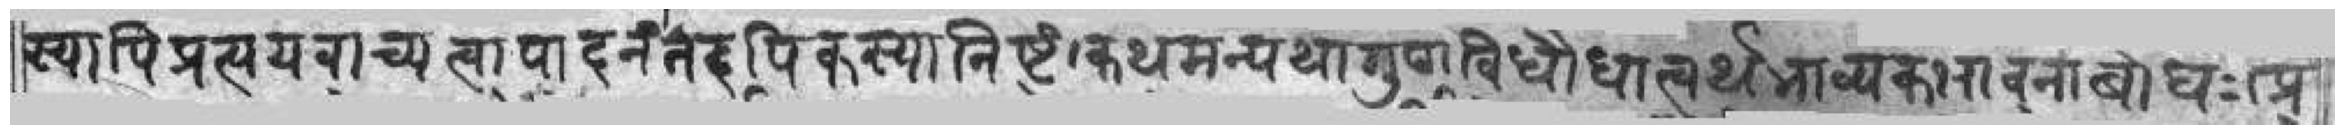

In [20]:
analyse_line(df,2)
#mark missing character as red too..




In [47]:
error_counts_train_paths = [
    fold_1_path + 'error_counts_train.json',
    # fold_2_path + 'error_counts_train.json',
    # fold_3_path + 'error_counts_train.json'
]
error_counts_test_paths = [
    fold_1_path + 'error_counts_test.json',
    # fold_2_path + 'error_counts_test.json',
    # fold_3_path + 'error_counts_test.json'
]


In [48]:
# Initialize an empty dictionary to store the combined data
data_train = {}

# Load and combine the JSON files
for path in error_counts_train_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_train.update(data)

data_test = {}

# Load and combine the JSON files
for path in error_counts_test_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_test.update(data)

In [49]:
def normalize_dict(d):
    total = sum(d.values())
    return {k: v/total for k, v in d.items()}

data_train = normalize_dict(data_train)
data_test = normalize_dict(data_test)

In [71]:

x = display_side_by_side(data_train, data_test, title1="Edits made to convert the recognition model predictions into the ground truth annotations (on train data).", title2="Edits made by the post correction model on the predictions of the recognition model (on test data)         .")


In [72]:
x

In [74]:
with open('/home/ocr_proj/OCR/post_correction/pe-ocr-sanskrit/outputs/html_error_hist', 'w', encoding='utf-8') as f:
        f.write(str(x))

In [ ]:
with open('output.html', 'w', encoding='utf-8') as f:
    f.write(str(x))